# Nighttime Lights with Rasterio and Datashader


GeoTIFF [data](https://ngdc.noaa.gov/eog/dmsp/download_radcal.html) from NOAA (single GeoTIFF: F16_20100111-20110731_rad_v4.avg_vis.tif):

> The Operational Linescan System (OLS) flown on the Defense Meteorological Satellite Program (DMSP) satellites, has a unique capability to record low light imaging data at night worldwide. These data are archived at the National Oceanic and Atmospheric Administration (NOAA) National Geophysical Data Center (NGDC).
 
Following this nice [tutorial](https://automating-gis-processes.github.io/CSC18/lessons/L6/reading-raster.html) on rasterio.

In [1]:
import rasterio
from rasterio.tools.mask import mask
import os
import datashader as ds
from datashader import transfer_functions as tf,
import xarray as xr
from colorcet import palette
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import json

## Open the file

In [2]:
data_path = '/media/francois/T5/data/Global_Radiance_Calibrated_Nighttime_Lights/'
file_name = 'F16_20100111-20110731_rad_v4.avg_vis.tif'  # data from 2010
file_path = os.path.join(data_path, file_name)

In [3]:
raster = rasterio.open(file_path)

## Check the raster attributes

In [4]:
type(raster)

rasterio._io.RasterReader

In [5]:
raster.crs

CRS({'init': 'epsg:4326'})

In [6]:
raster.bounds

BoundingBox(left=-180.00416666665, bottom=-65.00416610665, right=180.00416522665, top=75.00416666665)

We can see above that this raster file is covering most of the planet. 

## Mask / clip the raster

Let's crop it using a bounding box, in order to focus on South Europe and North Africa:

In [7]:
# WGS84 coordinates
minx, miny = -20., 20.
maxx, maxy =  30., 60.
bbox = box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
coords = [json.loads(geo.to_json())['features'][0]['geometry']]
out_img, out_transform = mask(raster=raster, shapes=coords, crop=True)

## Convert it to xarray DataArray

In [8]:
da = xr.DataArray(out_img)[0][::-1]

## Re-sample and display

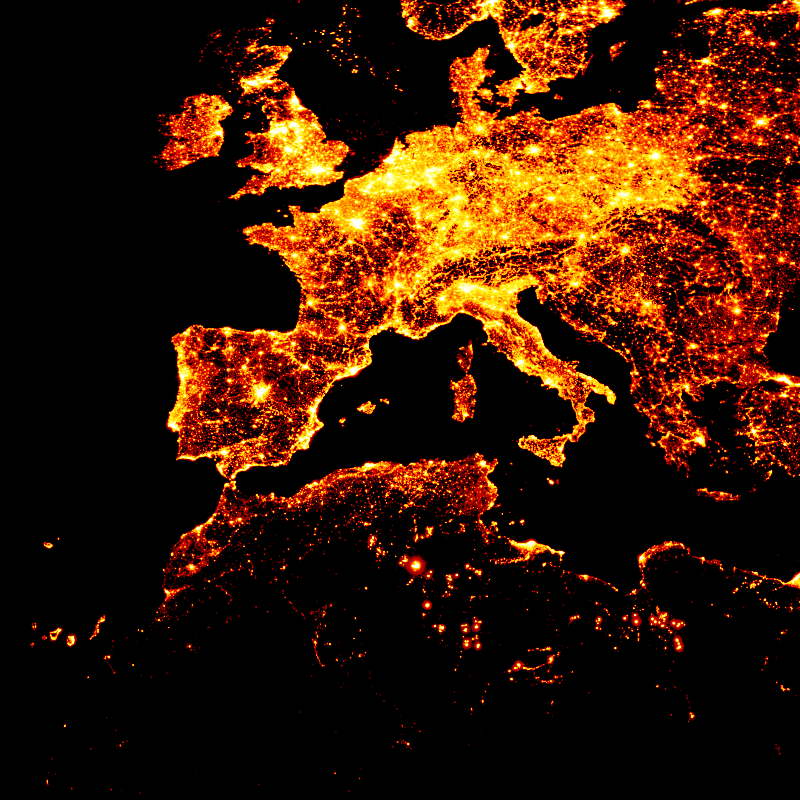

In [9]:
# colors
cmap = palette['fire']
bg_col = 'black'

cvs = ds.Canvas(plot_width=800, plot_height=800)
img = tf.shade(cvs.raster(da), cmap=cmap)
img = tf.set_background(img, bg_col)
img